1. Import Necessary Libraries


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix


2. Load the Augmented Data


In [2]:
# Load the augmented dataset
df = pd.read_excel('augmented_data.xlsx')

# Display the first few rows
df.head()


,Réf. Art,Désignation,Collection,Famille,Fournisseur,Réf Fourn.,Qte,Unite,Tva,Prix d'achat,Prix de Vente,Prix TTC,Units Sold,Best Sold Period
0,SSW451,ZINC CIMENT,Collection_20,Famille_16,SOCIETÉ NEAPOLIS ORTHOPEDIE,392,0.0,unit,7,42.0560,56.0750,60.0003,274,8-2024 to 12-2024
1,ZHR300,ZETA PLUS PUTTY,Collection_34,Famille_18,CHEDENT,401,0.0,unit,7,56.0750,70.0935,75.0000,144,8-2024 to 11-2024
2,ZHE_200,ZETA FLOW LIGHT,Collection_34,Famille_3,P.M.S,404,6.0,g,19,20.1680,25.2100,29.9999,204,10-2024 to 10-2024
3,VO13,XTRAFIL,Collection_48,Famille_9,ORTHODENTAL TUNISIE,399,2.0,unit,7,112.1495,158.8785,170.0000,65,8-2024 to 10-2024
4,D-TECH004,XT-ETCH GEL 10GR,Collection_3,Famille_15,SIDEM,396,12.0,g,7,13.0000,18.6920,20.0004,380,2-2024 to 11-2024


3. Data Preprocessing and Feature Engineering


In [3]:
# Check for missing values
print(df.isnull().sum())


Réf. Art            0
Désignation         0
Collection          0
Famille             0
Fournisseur         0
Réf Fourn.          0
Qte                 0
Unite               0
Tva                 0
Prix d'achat        0
Prix de Vente       0
Prix TTC            0
Units Sold          0
Best Sold Period    0
dtype: int64


3.2. Encoding Categorical Variables


In [4]:
# List of categorical columns to encode
categorical_cols = ['Désignation', 'Collection', 'Famille', 'Fournisseur', 'Unite']

# Initialize LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to each column
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])


3.3. Parsing the Best Sold Period


In [5]:
# Function to extract start and end months
def extract_months(period):
    start_month = int(period.split('-')[0])
    end_month = int(period.split(' ')[0].split('-')[0])
    return start_month, end_month

# Apply the function to create new columns
df['Start_Month'], df['End_Month'] = zip(*df['Best Sold Period'].apply(extract_months))

# Drop the original 'Best Sold Period' column
df = df.drop('Best Sold Period', axis=1)


4. Exploratory Data Analysis (EDA)


4.1. Distribution of Units Sold


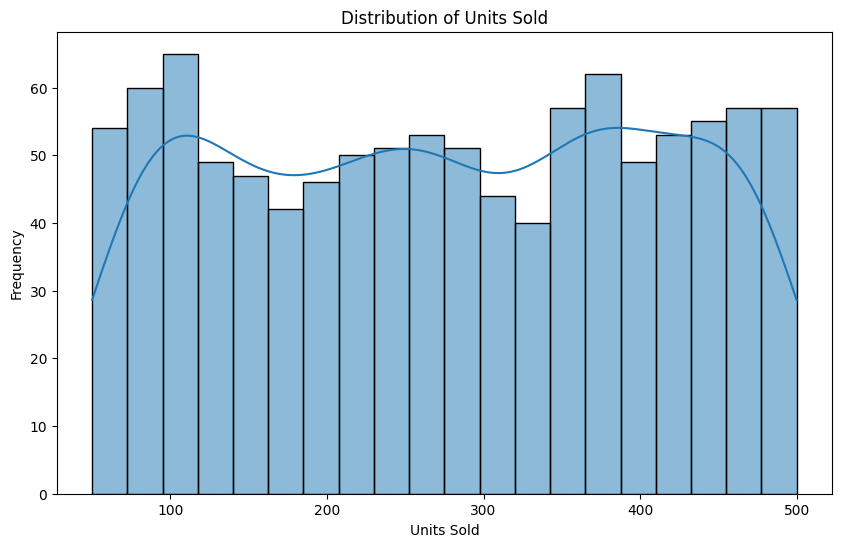

In [6]:
plt.figure(figsize=(10,6))
sns.histplot(df['Units Sold'], bins=20, kde=True)
plt.title('Distribution of Units Sold')
plt.xlabel('Units Sold')
plt.ylabel('Frequency')
plt.show()


4.2. Correlation Heatmap


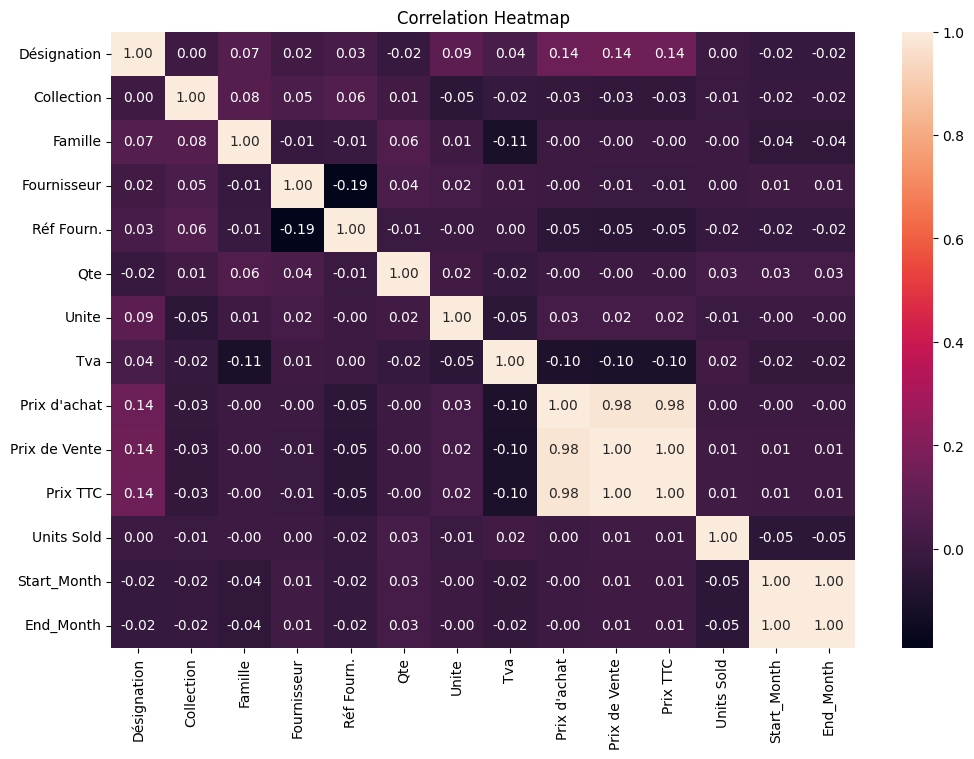

In [8]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

5. Building the Predictive Model




5.1. Creating the Target Variable


In [9]:
# Calculate the median units sold
median_units_sold = df['Units Sold'].median()

# Create the target variable
df['Sale_Category'] = df['Units Sold'].apply(lambda x: 'High Sale' if x > median_units_sold else 'Low Sale')

# Encode the target variable
df['Sale_Category'] = le.fit_transform(df['Sale_Category'])


5.2. Selecting Features and Target


In [10]:
# Features
X = df.drop(['Réf. Art', 'Units Sold', 'Sale_Category'], axis=1)

# Target
y = df['Sale_Category']



5.3. Splitting the Data



In [11]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


5.4. Training the Model


In [15]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the model
model = DecisionTreeClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

6. Evaluating the Model


6.1. Making Predictions


In [16]:
# Make predictions on the test set
y_pred = model.predict(X_test)


6.2. Classification Report


In [17]:
# Print classification report
print(classification_report(y_test, y_pred, target_names=['Low Sale', 'High Sale']))


              precision    recall  f1-score   support

    Low Sale       0.54      0.45      0.49       110
   High Sale       0.48      0.57      0.52        99

    accuracy                           0.51       209
   macro avg       0.51      0.51      0.51       209
weighted avg       0.51      0.51      0.51       209



6.3. Confusion Matrix


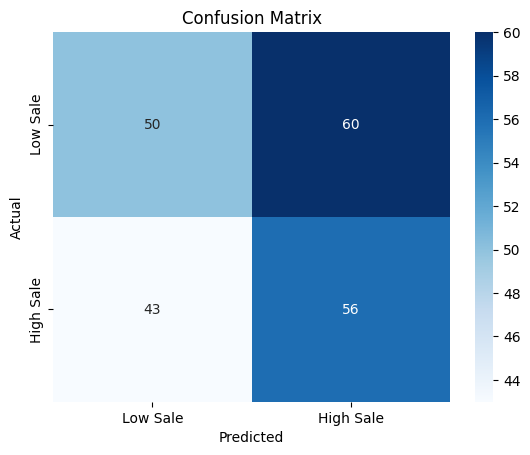

In [18]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Low Sale', 'High Sale'], yticklabels=['Low Sale', 'High Sale'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


7. Predicting Most Sold Articles for a Given Period


In [21]:
def predict_high_sale_articles(start_month, end_month):
    # Adjusted filtering condition
    period_df = df[(df['Start_Month'] <= end_month) & (df['End_Month'] >= start_month)]

    if period_df.empty:
        print("No articles found for the given period.")
        return pd.DataFrame()  # Return empty DataFrame or handle accordingly

    X_period = period_df.drop(['Réf. Art', 'Units Sold', 'Sale_Category'], axis=1)

    predictions = model.predict(X_period)
    period_df = period_df.copy()  # To avoid SettingWithCopyWarning
    period_df['Predicted_Sale_Category'] = predictions
    high_sale_articles = period_df[period_df['Predicted_Sale_Category'] == 1]
    return high_sale_articles[['Réf. Art', 'Désignation', 'Units Sold']]


In [31]:
start_month = 3
end_month = 5
high_sale_articles = predict_high_sale_articles(start_month, end_month)

if not high_sale_articles.empty:
    print("Predicted High Sale Articles from March to May 2024:")
    display(high_sale_articles)
else:
    print("No high sale articles predicted for the given period.")


Predicted High Sale Articles from March to May 2024:


,Réf. Art,Désignation,Units Sold
18,MOL 125,1014,58
19,DE600-503-30,1013,118
21,CO245,1011,161
27,ZIANN03,1004,107
28,DIV9547,1003,266
...,...,...,...
1010,ZHR1,30,90
1012,CV12,28,129
1020,DIV4571,20,252
1027,BE03,13,81


In [23]:
import joblib

# Save the trained model to a file
model_filename = 'decision_tree_model.joblib'
joblib.dump(model, model_filename)

print(f"Model saved to {model_filename}")


Model saved to decision_tree_model.joblib


In [28]:
from sklearn.preprocessing import LabelEncoder

encoders = {}
categorical_cols = ['Désignation', 'Collection', 'Famille', 'Fournisseur', 'Unite']

for col in categorical_cols:
    le = LabelEncoder()
    le.fit(df[col])  # Fit on original string data
    df[col] = le.transform(df[col])  # Transform the data
    encoders[col] = le

In [30]:
# Save the encoders dictionary
joblib.dump(encoders, 'label_encoderss.joblib')


['label_encoderss.joblib']

In [26]:
median_filename = 'median_units_sold.joblib'
joblib.dump(median_units_sold, median_filename)


['median_units_sold.joblib']

In [27]:
features_filename = 'model_features.joblib'
joblib.dump(X_train.columns.tolist(), features_filename)


['model_features.joblib']